In [14]:
import torchvision
print(torchvision.__version__)

0.23.0+cu126


## [1] 사전학습 모델 튜닝없이 사용

In [23]:
from torchvision import models
print(dir(models)[:5])

['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights']


In [28]:
# help(models.AlexNet)

In [24]:
import inspect
print(inspect.signature(models.AlexNet))

(num_classes: int = 1000, dropout: float = 0.5) -> None


In [49]:
## ImageNet 클래스 라벨 가져와 .txt로 저장하기
import urllib.request
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")

## 저장된 txt파일 읽어서 라인단위로 분리해 classes변수에 넣기

with open("imagenet_classes.txt") as f:
      classes = [line.strip() for line in f.readlines()]


torch.Size([1, 3, 224, 224])

 ->예측된 클래스번호: 285
 ->예측된 클래스: Egyptian cat


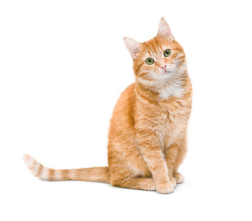

torch.Size([1, 3, 224, 224])

 ->예측된 클래스번호: 265
 ->예측된 클래스: toy poodle


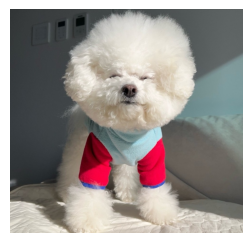

torch.Size([1, 3, 224, 224])

 ->예측된 클래스번호: 628
 ->예측된 클래스: liner


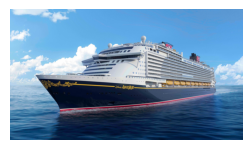

torch.Size([1, 3, 224, 224])

 ->예측된 클래스번호: 283
 ->예측된 클래스: Persian cat


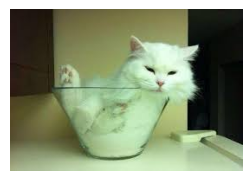

In [51]:
# alexnet
import torch
from torchvision import models, transforms
from PIL import Image

import matplotlib.pyplot as plt

# 1. 사전학습된 AlexNet 불러오기
model = models.alexnet(weights="IMAGENET1K_V1")
model.eval()

# 2. 전처리 파이프라인 (ImageNet 규격)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet 평균
        std=[0.229, 0.224, 0.225]     # ImageNet 표준편차
    ),
])


# 3. 예시 이미지 불러오기 (로컬 파일도 가능)
img_list=["/content/추론cat.jpg","/content/추론dog.jpg","/content/추론ship.jpg","/content/추론cat2.jpg"]
for imgfile in img_list:
  img = Image.open(imgfile)
  x = preprocess(img).unsqueeze(0)
  print(x.shape) # 모델에서 요구하는 1, 3,224,224

  # 4. 추론
  with torch.no_grad():
      outputs = model(x)
      _, predicted = outputs.max(1)


  print("\n ->예측된 클래스번호:", predicted.item())
  print(" ->예측된 클래스:", classes[predicted.item()])
  plt.figure(figsize=(3,3))
  plt.axis('off')   # x, y 축 모두 숨김
  plt.imshow(img)
  plt.show()


### [2] 객체인식 모델

In [96]:
from torchvision.models.detection import  FasterRCNN_ResNet50_FPN_Weights

# 1. 가중치 불러오기
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# 2. 메타데이터 확인
meta = weights.meta
print(meta.keys())
print(len(meta["categories"]))   # 학습된 클래스 개수 (COCO: 91개)
print(meta["categories"])        # 클래스 이름 리스트


dict_keys(['categories', 'min_size', 'num_params', 'recipe', '_metrics', '_ops', '_file_size', '_docs'])
91
['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vas

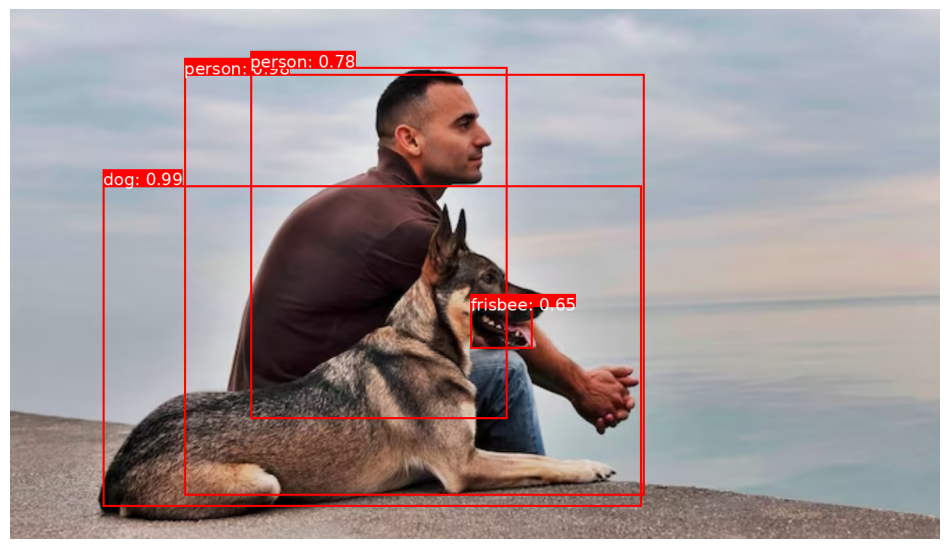

In [107]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# 1. 모델 & 가중치 불러오기
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
model.eval()

# 2. COCO 클래스 이름
categories = weights.meta["categories"]

# 3. 이미지 불러오기
img = Image.open("test.jpg").convert("RGB")

# 4. 전처리
transform = weights.transforms()
img_tensor = transform(img)

# 5. 추론
with torch.no_grad():
    preds = model([img_tensor])[0]

# 6. 바운딩박스 + 라벨 출력
draw = ImageDraw.Draw(img)

try:
    font = ImageFont.truetype("DejaVuSans.ttf", 24)
except:
    font = ImageFont.load_default()

for box, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
    if score < 0.5:
        continue
    x1, y1, x2, y2 = box

    # 박스
    draw.rectangle(((x1, y1), (x2, y2)), outline="red", width=3)

    # 레이블 + 점수
    text = f"{categories[label]}: {score:.2f}"
    bbox = font.getbbox(text)
    text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # 텍스트 배경 박스
    draw.rectangle(((x1, y1 - text_h), (x1 + text_w, y1)), fill="red")

    # 텍스트 출력
    draw.text((x1, y1 - text_h), text, fill="white", font=font)

# 7. 출력
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.show()


In [110]:
preds

{'boxes': tensor([[133.6411, 253.0369, 907.3293, 714.1038],
         [250.3799,  93.6413, 911.8163, 698.6321],
         [345.0021,  83.8901, 714.0018, 588.7512],
         [661.6443, 427.9113, 750.5852, 487.8964],
         [350.9706, 244.5482, 754.8057, 602.7309],
         [124.0559, 309.4060, 834.2094, 742.5455],
         [503.6586, 251.9989, 889.4290, 631.3547],
         [593.5118, 189.7045, 901.5347, 630.3697]]),
 'labels': tensor([18,  1,  1, 34, 18, 17, 18,  1]),
 'scores': tensor([0.9943, 0.9810, 0.7800, 0.6485, 0.4445, 0.1940, 0.1599, 0.0881])}

## [2] 세그멘테이션 모델

In [86]:
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

# 가중치 불러오기
weights = DeepLabV3_ResNet50_Weights.DEFAULT
meta = weights.meta
print(meta.keys())
print(len(meta["categories"]))  # 학습된 클래스 레이블 목록
print(meta["categories"])

dict_keys(['categories', 'min_size', '_docs', 'num_params', 'recipe', '_metrics', '_ops', '_file_size'])
21
['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


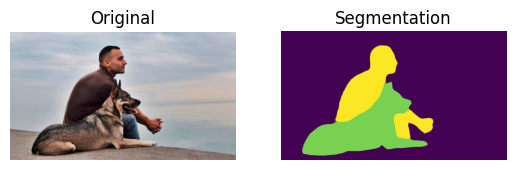

In [74]:
#####################
## 전이학습 모델중 세그멘테이션
##############################
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 1. 모델 불러오기
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)
model.eval()

# 2. 전처리 파이프라인 (weights에 내장된 transform 사용 가능)
preprocess = weights.transforms()

# 3. 이미지 불러오기
img = Image.open("/content/test.jpg")
x = preprocess(img).unsqueeze(0)

# 4. 추론
with torch.no_grad():
    output = model(x)["out"][0]   # [num_classes, H, W]
pred = output.argmax(0)

# 5. 시각화
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred)
plt.title("Segmentation")
plt.axis("off")

plt.show()


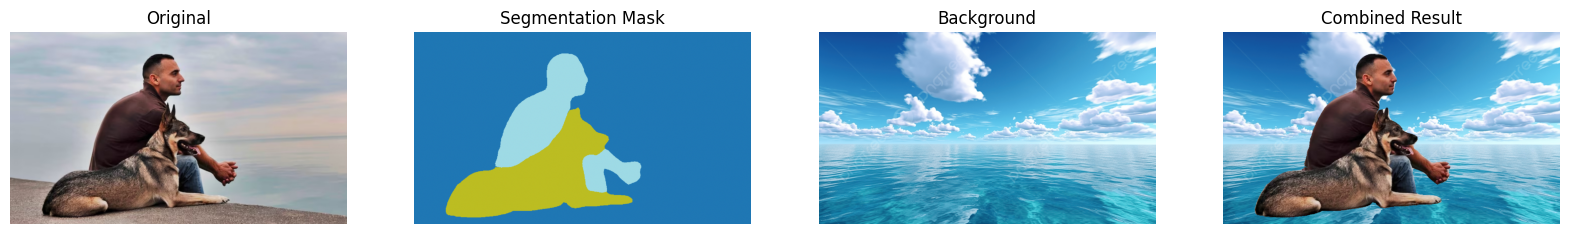

In [80]:
#################################
## 배경합성
################################
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

# 1. 세그멘테이션 모델 불러오기
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights).eval()
preprocess = weights.transforms()

# 2. 원본 & 배경 불러오기
img = cv2.imread("test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

background = cv2.imread("background.jpg")
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = cv2.resize(background, (img.shape[1], img.shape[0]))

# 3. 추론
pil_img = Image.fromarray(img)
input_tensor = preprocess(pil_img).unsqueeze(0)
with torch.no_grad():
    out = model(input_tensor)["out"][0]
pred = out.argmax(0).byte().cpu().numpy()
pred_resized = cv2.resize(pred, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

# 4. 사람(15) + 강아지(12) 마스크
mask = ((pred_resized == 15) | (pred_resized == 12)).astype(np.uint8)

# 5. 합성
mask_3ch = np.repeat(mask[:, :, None], 3, axis=2)
combined = img * mask_3ch + background * (1 - mask_3ch)

# 6. 시각화 (원본 / 세그멘테이션 / 배경 / 합성)
plt.figure(figsize=(20,6))

plt.subplot(1,4,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(pred_resized, cmap="tab20")  # 세그멘테이션 마스크
plt.title("Segmentation Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(background)
plt.title("Background")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(combined.astype(np.uint8))
plt.title("Combined Result")
plt.axis("off")

plt.show()
